In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

# Get a feel of the data 

Let's first load the data the preprocessed data, which now only contain "Apple"-related quotes. 

We will load a subset of the data. Loading 50.000 quotes:

In [13]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))
#df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))

In [14]:
df

,quoteID,quotation,speaker,date,numOccurrences
0,2020-03-29-000118,... Zane Lowe checks in via FaceTime with Elto...,None,2020-03-29 17:47:52,1
1,2020-02-13-007205,Apple prices generally peak in January. Betwee...,Sarah Johnson,2020-02-13 10:01:48,3
2,2020-01-23-044076,"I'm not sure why Apple did this,",Roger Grimes,2020-01-23 17:15:24,2
3,2020-01-02-039024,new multi-year license agreement under which A...,None,2020-01-02 09:56:04,3
4,2020-01-19-037883,the best sort of deal they could have come up ...,Dickie Arbiter,2020-01-19 19:24:59,1
...,...,...,...,...,...
21483,2015-10-02-101639,"This is a mindset for permanent growth, becaus...",Terry Bell,2015-10-02 03:12:52,5
21484,2015-01-29-102007,We estimate [ that the pace of iPhone upgrades...,Andy Hargreaves,2015-01-29 17:52:13,3
21485,2015-05-18-003700,Apple has a world-class recycling program.,Tim Cook,2015-05-18 15:08:25,3
21486,2015-09-09-009615,"At the same time, those who purchase four pack...",Jason Teoh,2015-09-09 23:40:41,1


## Analysis

## 1. Who has most quotes attributed to them?

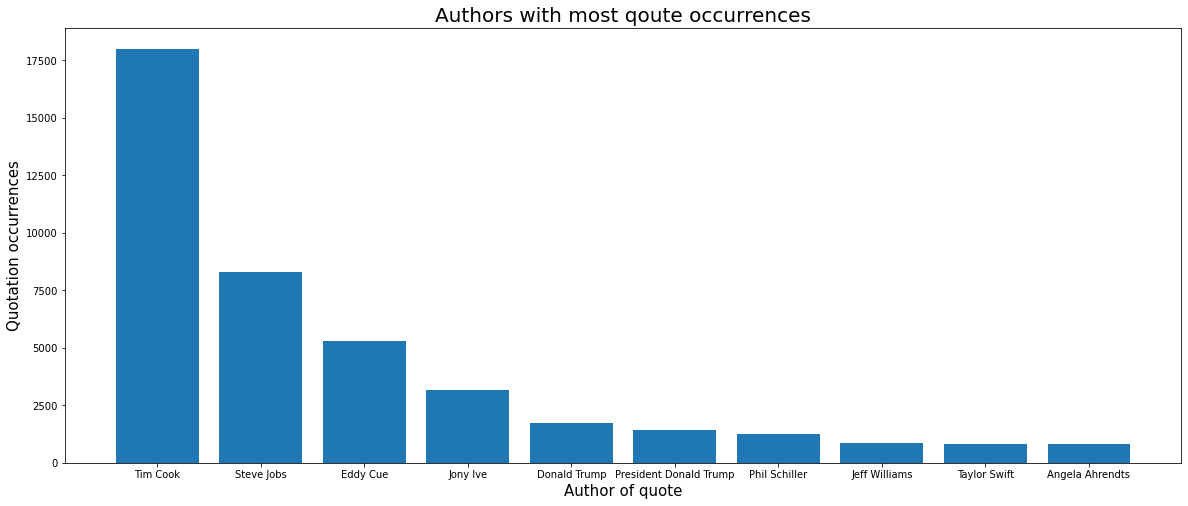

In [17]:
top_speakers = df.loc[df.speaker != 'None'].groupby(by=['speaker']).sum().sort_values(by='numOccurrences',ascending=False).reset_index()
fig,ax = plt.subplots(figsize=(20,8))
ax.bar(top_speakers.speaker[:10],top_speakers.numOccurrences[:10])
ax.set_xlabel("Author of quote",size=15)
ax.set_ylabel("Quotation occurrences",size=15)
#plt.xticks(top_speakers.speaker1[:10],rotation=90)
ax.set_title("Authors with most qoute occurrences",size=20)
plt.show()

We see that most of the quotes are from politicians - probably because of the profile of NY-times

## 2. How does the daily number of quotes vary throughout the year?

In [18]:
df['date_clean'] = df.apply(lambda x: x['date'][:10],axis=1)

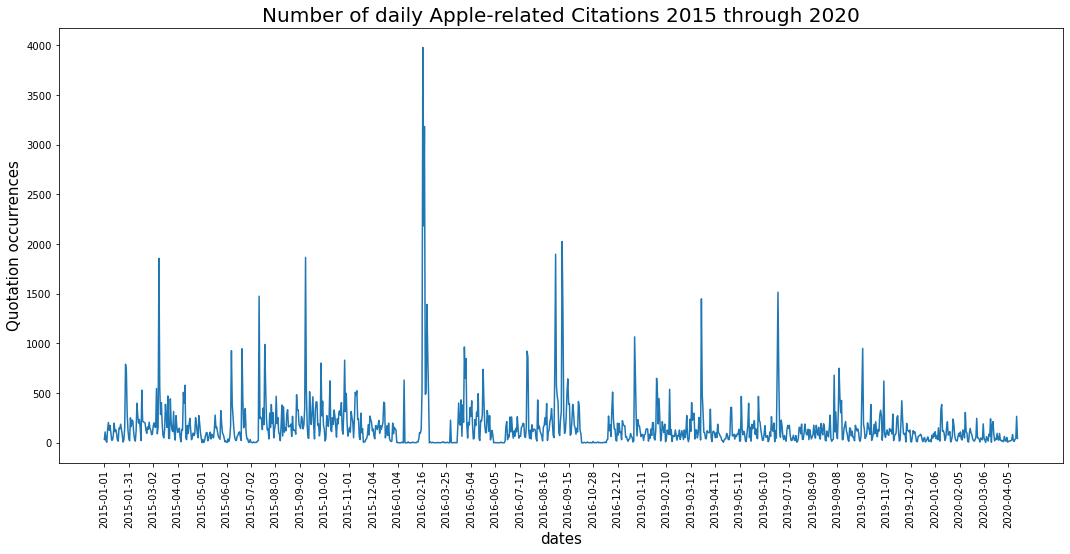

In [21]:
time = df.groupby(['date_clean']).sum().index
quote_num = df.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(time,quote_num)
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
plt.show()


Comment: TODO

## 3. How does the distribution of quote occurences look?

Text(0.5, 1.0, 'Distribution of quote occurrences (Occurrences capped at 60)')

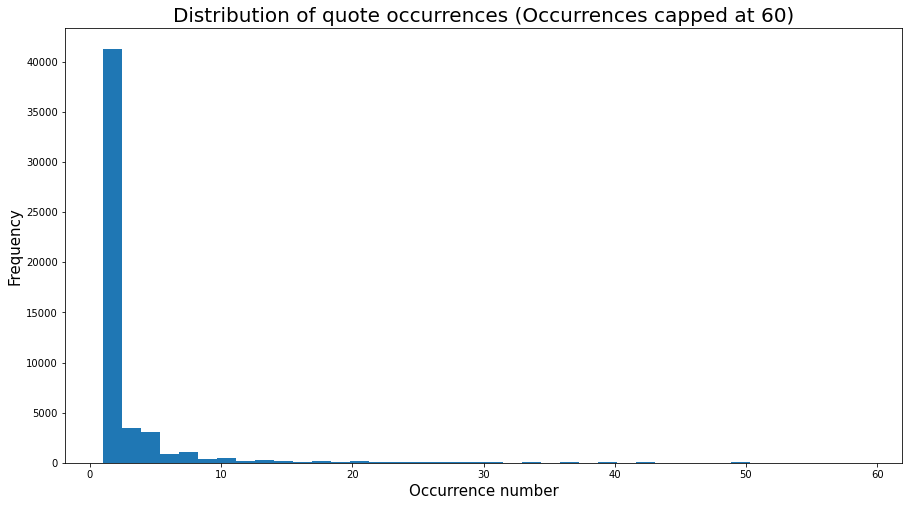

In [22]:
fig,ax = plt.subplots(figsize=(15,8))
ax.hist(df.numOccurrences[df.numOccurrences < 60],bins=40);
ax.set_xlabel("Occurrence number",size=15)
ax.set_ylabel("Frequency",size=15)
ax.set_title("Distribution of quote occurrences (Occurrences capped at 60)",size=20)

## 4. How does the most frequent quoters vary throughout the year?

In [23]:
#Extracting dataset and formatting date
quotes_per_date = df.copy()
quotes_per_date['date'] = quotes_per_date['date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))


In [24]:
#Extracting dataset and formatting date to show only month
quotes_per_month = df.copy()
quotes_per_month['date'] = quotes_per_month['date'].apply(lambda x: dt.datetime.strptime(x[:7], '%Y-%m'))

In [25]:
#Pivoting table such that each column is a speaker and index is date
#Merging Donald Trump quotations and dropping None as well
quotes_per_date = quotes_per_date.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0)
quotes_per_date['Donald Trump'] = quotes_per_date['Donald Trump'] + \
                                  quotes_per_date['President Donald Trump'] + \
                                  quotes_per_date['President Trump']
quotes_per_date.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

quotes_per_month = quotes_per_month.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0)
quotes_per_month['Donald Trump'] = quotes_per_month['Donald Trump'] + \
                                   quotes_per_month['President Donald Trump'] + \
                                   quotes_per_month['President Trump']
quotes_per_month.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

In [26]:
#Cummulative representation of quotes
cummulative_quotes_per_date = quotes_per_date.cumsum(axis=0)
cummulative_quotes_per_month = quotes_per_month.cumsum(axis=0)


### Code for making a .mp4 file with the animation

In [281]:
import bar_chart_race as bcr

In [287]:
quotes_per_date_plot = bcr.bar_chart_race(cummulative_quotes_per_month, filename='quotes_per_date_plot.mp4',
                                          n_bars=10, filter_column_colors=True, period_length=1000, steps_per_period=20,
                                          title='Most frequently quoted people', period_fmt='%B %Y',    
                                          shared_fontdict={'family' : 'Helvetica', 'color' : '.1'}
)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 131 missing from current fon

### Time series quote occurences for the most frequent quoters

Plottet by week below


In [27]:
#Grouping by week and aggregating occurrences
quotes_per_week = quotes_per_date.copy()
quotes_per_week['week'] = quotes_per_week.index
quotes_per_week['week'] = quotes_per_week['week'].apply(lambda x: dt.date.isocalendar(x)[1])
quotes_per_week = quotes_per_week.groupby('week').sum()

In [28]:
#Cummulative representation of quotes per week
cummulative_quotes_per_week = quotes_per_week.cumsum(axis=0)

In [29]:
#Extract most frequent quoters
top_quoters = quotes_per_week.sum(axis=0).nlargest(6).index

In [30]:
#Extracting these from week dataset
top_quotes_per_week = quotes_per_week[top_quoters]
cummulative_top_quotes_per_week = cummulative_quotes_per_week[top_quoters]

### Normal Plot

Text(0, 0.5, 'Number of quotations')

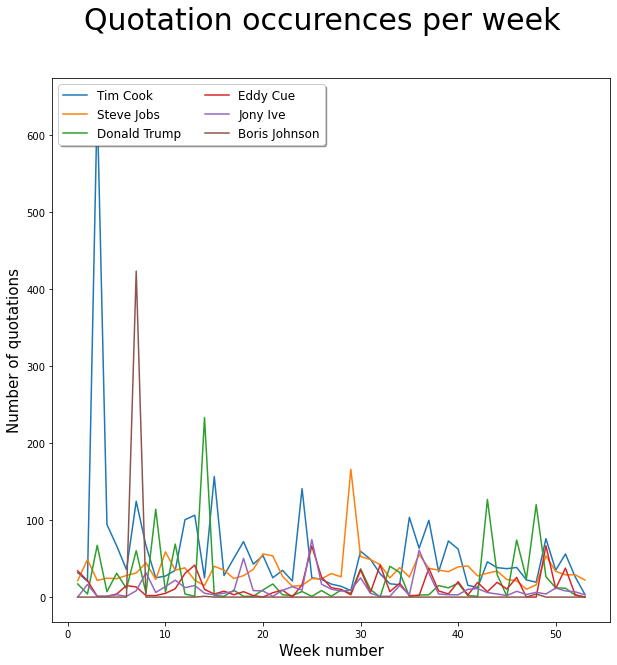

In [31]:
fig = plt.figure(figsize=(10, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(top_quotes_per_week.index, top_quotes_per_week[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Quotation occurences per week', fontsize=30)
plt.xlabel('Week number', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)


### Cummulative plot

Text(0, 0.5, 'Number of quotations')

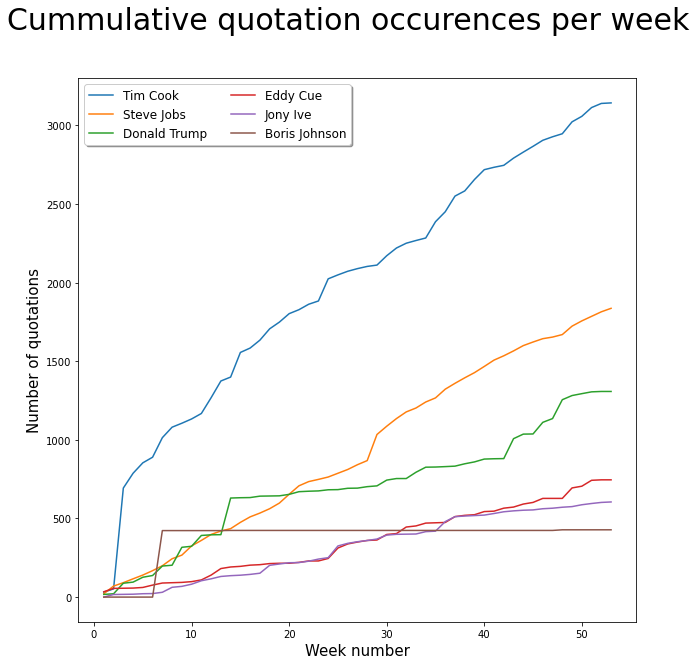

In [32]:
fig = plt.figure(figsize=(10, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(cummulative_top_quotes_per_week.index, cummulative_top_quotes_per_week[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Cummulative quotation occurences per week', fontsize=30)
plt.xlabel('Week number', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)

